In [2]:
import numpy as np
from lab.classifiers.kfingerprinting import ALL_DEFAULT_FEATURES
from pathlib import Path
import pathlib
import pandas as pd
import json
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from lab import tracev2

DIRECTORY = f"../../results/delay-vs-drop/tamaraw/delay.sizes/"
# DIRECTORY = f"../../results/delay-vs-drop/tamaraw/delay.300mult/"
feature_names = np.array(ALL_DEFAULT_FEATURES)
# %matplotlib widget

In [3]:
with h5py.File(Path(DIRECTORY, "dataset.sim.h5"), mode="r") as h5in:
    classes = h5in["labels"]["class"]
    sizes = h5in["sizes"][:]

In [4]:
sizes_arr = np.zeros((len(sizes), max(len(x) for x in sizes)), dtype=int)
for i, arr in enumerate(sizes):
    sizes_arr[i, :len(arr)] = arr
sizes_arr

array([[ 750, -750, -750, ...,    0,    0,    0],
       [ 750, -750, -750, ...,    0,    0,    0],
       [ 750, -750, -750, ...,    0,    0,    0],
       ...,
       [ 750, -750, -750, ...,    0,    0,    0],
       [ 750, -750, -750, ...,    0,    0,    0],
       [ 750, -750, -750, ...,    0,    0,    0]])

In [5]:
frame = pd.DataFrame({"out": np.sum(sizes_arr > 0, axis=1),
                      "in": np.sum(sizes_arr < 0, axis=1),
                      "class": classes})
frame

,out,in,class
0,100,300,0
1,100,400,0
2,100,400,0
3,100,300,0
4,100,300,0
...,...,...,...
1995,800,3200,19
1996,800,2900,19
1997,700,2600,19
1998,800,3100,19


In [6]:
p = frame.groupby(["out", "in"]).agg(["nunique", "size"])
p.groupby([("class", "nunique")]).sum()

,class
,size
"(class, nunique)",
1,273
2,292
3,371
4,190
5,253
6,442
7,179


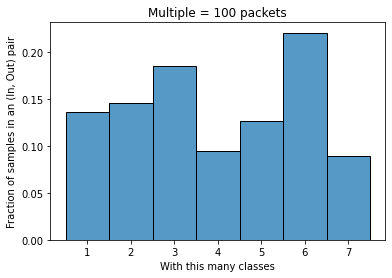

In [7]:
def plot_at_multiple(frame, multiple: int, ax=None, alt=False):
    ax = ax or plt.subplots()[1]
    
    frame = frame.copy()
    frame["out"] = frame["out"] + (multiple - (frame["out"] % multiple))
    frame["in"] = frame["in"] + (multiple - (frame["in"] % multiple))
    assert (frame[["in", "out"]] % multiple == 0).all().all()
    
    ax.set_title(f"Multiple = {multiple} packets")
    if not alt:
        plot_data = frame.groupby(["out", "in"]).nunique().squeeze()
        sns.histplot(x=plot_data, discrete=True, stat="probability", ax=ax)
        ax.set_ylabel("Fraction of Unique (In, Out) pairs")
        ax.set_xlabel("With this many classes having a sample within it")
    else:
        plot_data = frame.groupby(["out", "in"]).agg(["nunique", "size"])
        plot_data = plot_data.groupby([("class", "nunique")]).sum().reset_index()
        sns.histplot(x=plot_data[("class", "nunique")], weights=plot_data[("class", "size")], ax=ax, stat="probability", discrete=True)
        ax.set_ylabel("Fraction of samples in an (In, Out) pair")
        ax.set_xlabel("With this many classes")
    
plot_at_multiple(frame, 100, alt=True)


<AxesSubplot:xlabel='None-rank', ylabel='out-in'>

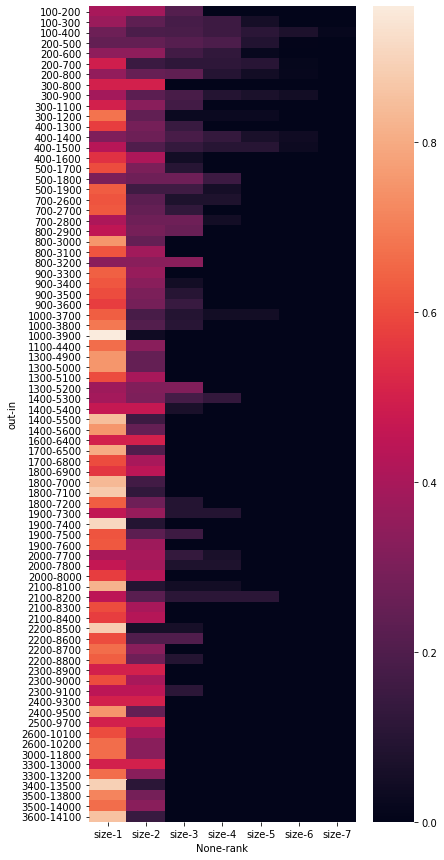

In [8]:
alt = frame.groupby(["out", "in", "class"]).size().rename("size").to_frame()
alt["rank"] = alt.groupby(["out", "in"])["size"].rank(method="first", ascending=False).astype(int)
alt["rank"] = alt["rank"]
alt = alt.reset_index("class", drop=True).reset_index().pivot(columns="rank", index=["out", "in"]).fillna(0).astype(int)
# alt.sort_values(by=("size", 1), ascending=False).head(50)

alt = alt[alt[("size", 2)] != 0]
alt["sum"] = alt.sum(axis=1)
alt = alt.loc[:, [("size", i) for i in range(1, 8)]].div(alt["sum"], axis=0)
alt

fig, ax = plt.subplots(figsize=(6, 15))
sns.heatmap(alt, ax=ax)


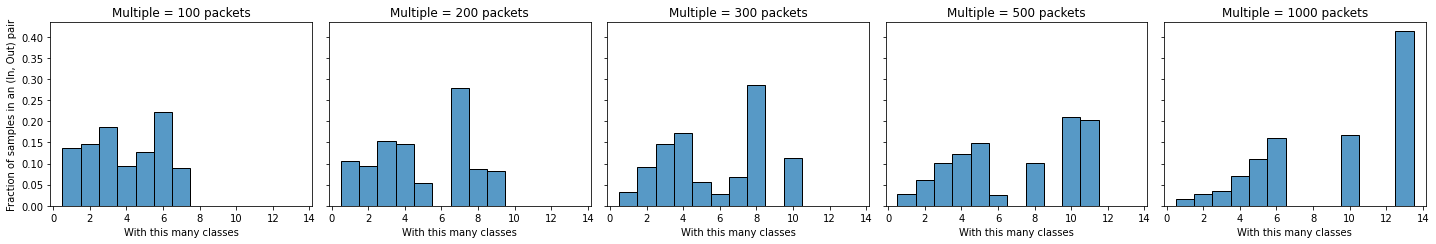

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3.5), sharex=True, sharey=True)

for i, multiple in enumerate([100, 200, 300, 500, 1000]):
    plot_at_multiple(frame, multiple, ax=axes[i], alt=True)
fig.tight_layout()
fig.savefig("/tmp/anon_set.jpg", dpi=150)

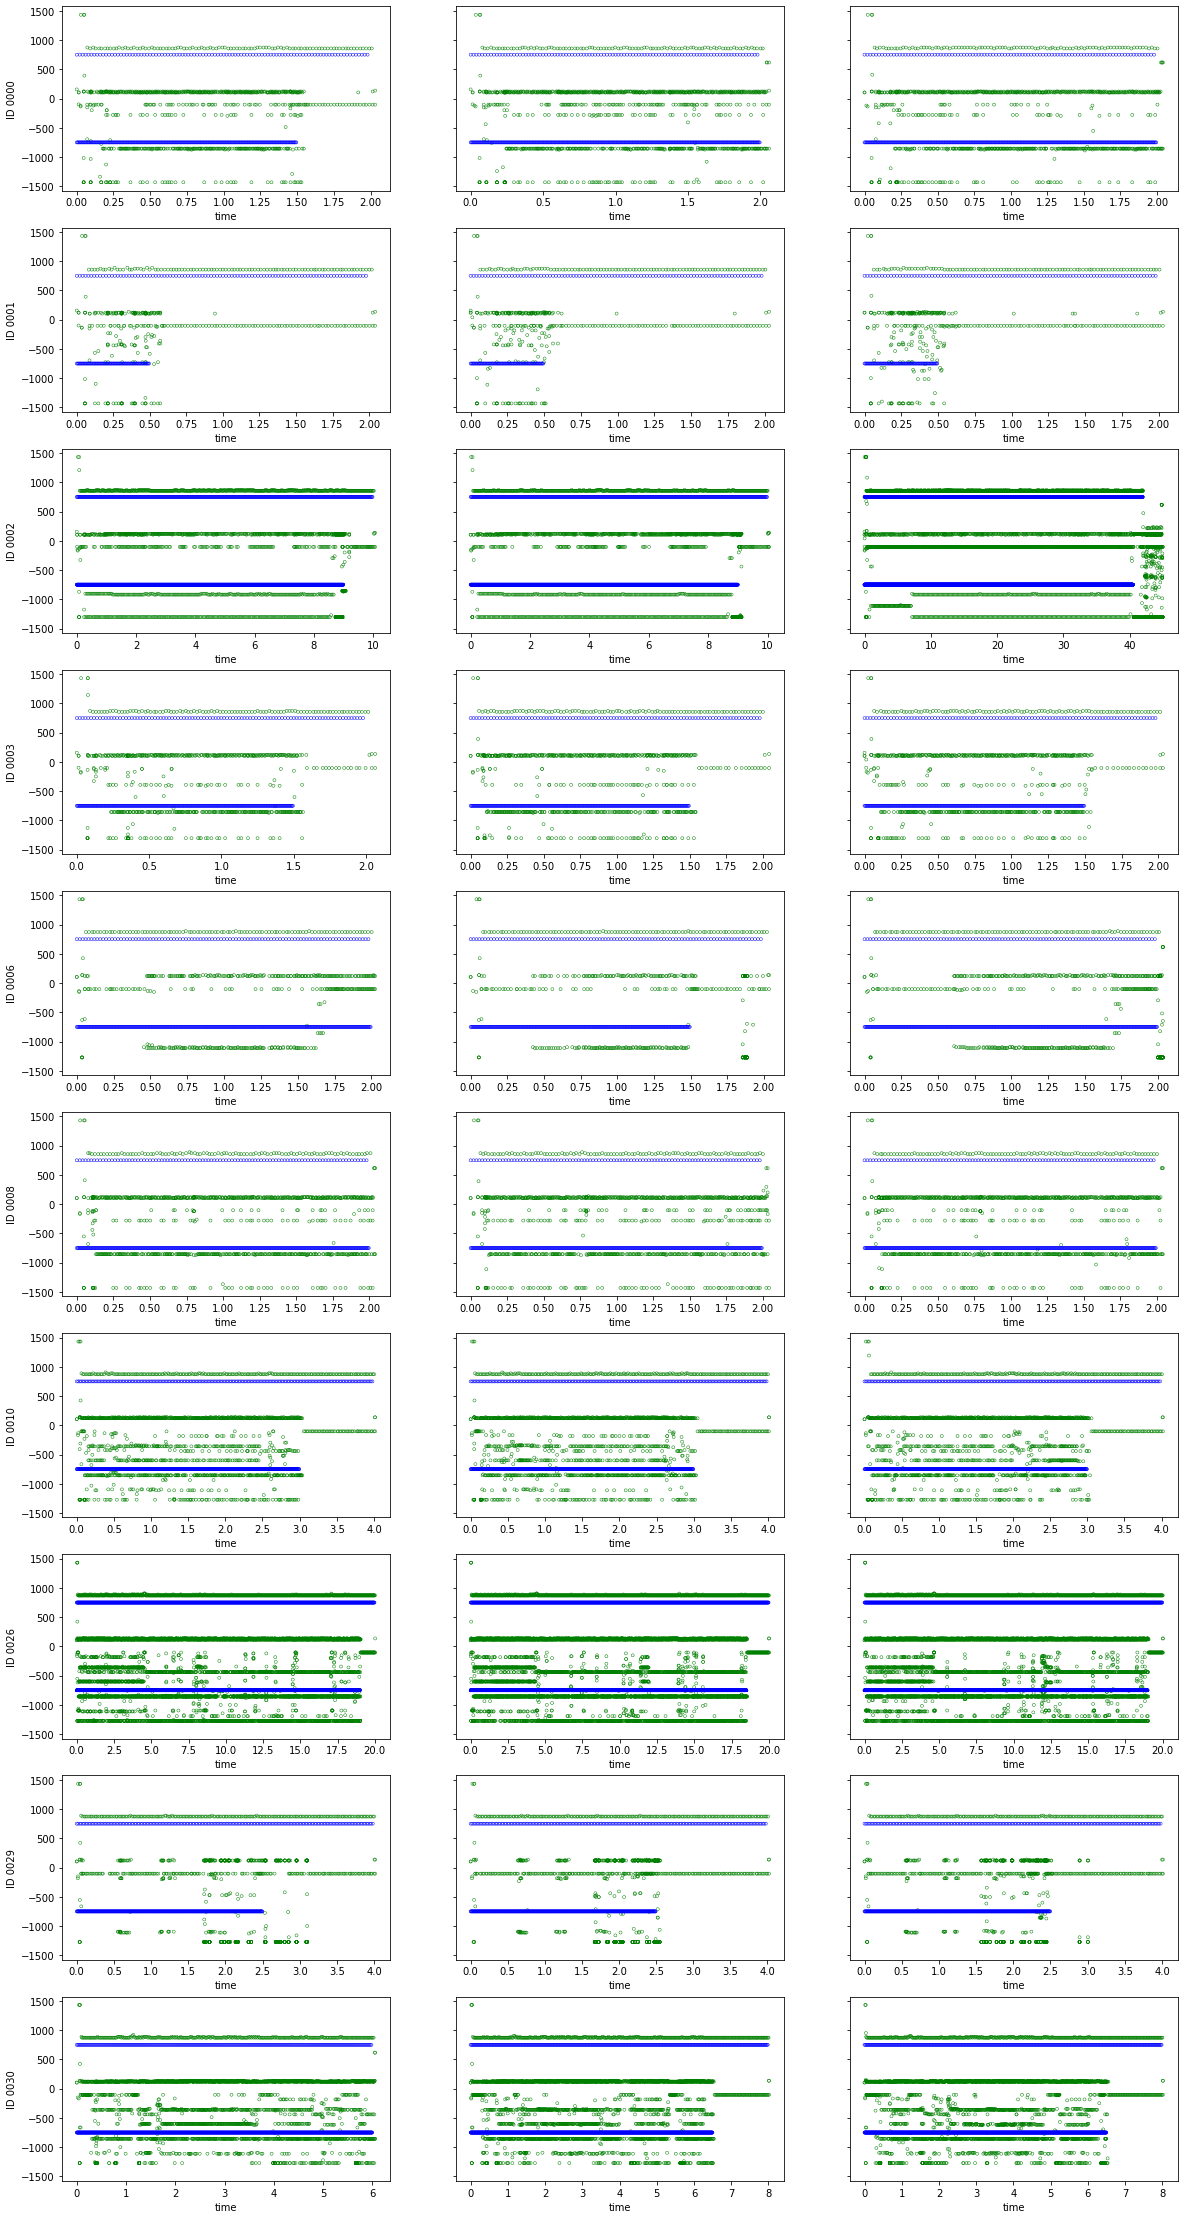

In [12]:
fig, ax = plt.subplots(10, 3, sharex=False, sharey=True, figsize=(20, 40))

for i, id_ in enumerate([0, 1, 2, 3, 6, 8, 10, 26, 29, 30]):
    for region in range(3):
        # trace_data = pd.DataFrame(tracev2.from_csv(Path(DIRECTORY, "dataset", f"{id_:04d}", f"{region}_0", "trace.csv")))
        trace_data = pd.DataFrame(tracev2.from_csv(Path(DIRECTORY, "dataset", f"{id_:04d}", f"0_{region}", "trace.csv")))
        # trace_data = trace_data[trace_data["size"].abs() > 150]
        sns.scatterplot(data=trace_data, x="time", y="size", ax=ax[i, region], marker='.', edgecolor="green", facecolor="none")
        trace_data = pd.DataFrame(tracev2.from_csv(Path(DIRECTORY, "dataset", f"{id_:04d}", f"0_{region}", "schedule.csv")))
        sns.scatterplot(data=trace_data, x="time", y="size", ax=ax[i, region], marker='.', edgecolor="blue", facecolor="none")
    ax[i, 0].set_ylabel(f"ID {id_:04d}")
fig.savefig("/tmp/traces.jpg", bbox_inches="tight", dpi=150)

<AxesSubplot:xlabel='time', ylabel='size'>

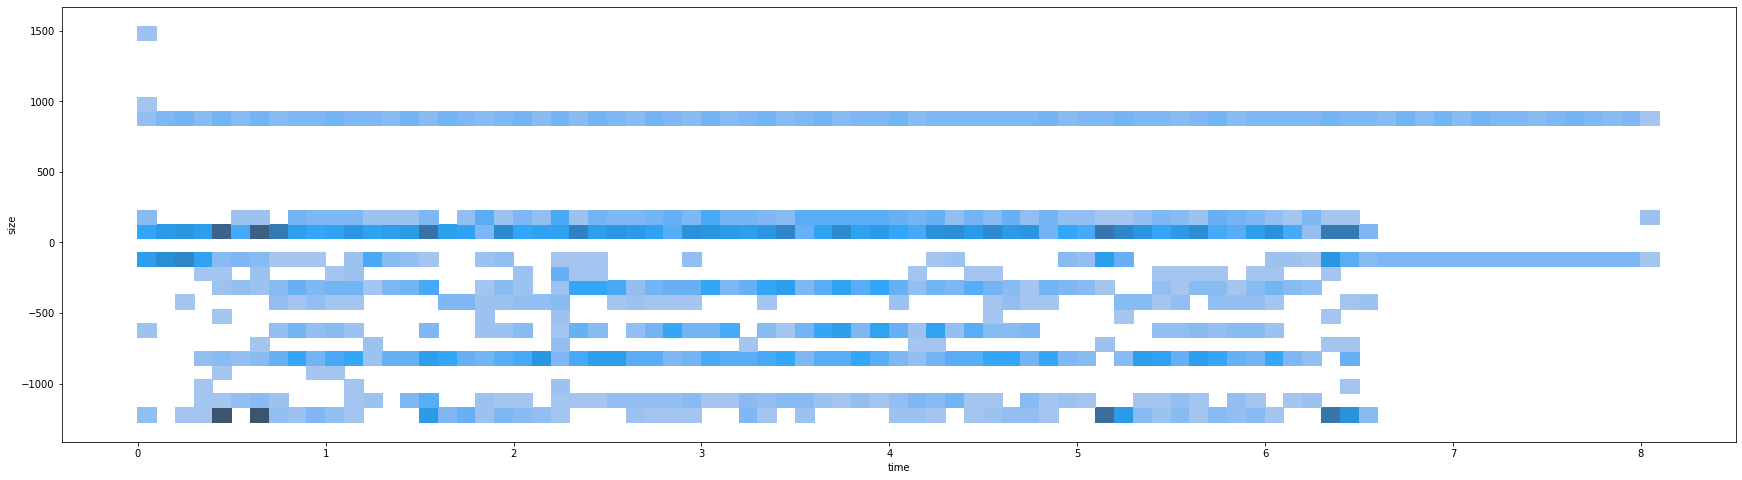

In [26]:
trace_data = pd.DataFrame(tracev2.from_csv(Path(DIRECTORY, "dataset", f"{id_:04d}", f"0_{region}", "trace.csv")))

fig, ax = plt.subplots(figsize=(30, 8))
sns.histplot(data=trace_data, x="time", y="size", binwidth=(0.100, 100), legend=True, ax=ax)